In [1]:
using Plots


include("distributions.jl")
include("distances/new_distance.jl")
include("distances/distance_Wasserstein.jl")


ww (generic function with 2 methods)

In [2]:
# given two laws of random probability measures, generate distances between hierarchical
# empirical Measures

function sample_distances(q_1::PPM, q_2::PPM, n::Int, m::Int, s::Int)
    # this function samples distances between hierarchical empirical measures
    # n : number of probability measures from which observations are generated
    # m : number of observations from each probability measure
    # s : number of times to sample distance between empirical measures

    d_lips = Vector{Float64}(undef, s)
    for i in 1:s
        emp_1, emp_2 = generate_emp(q_1, n, m), generate_emp(q_2, n, m)
        d_lips[i] = dlip(emp_1, emp_2)
    end
    return d_lips
end

sample_distances (generic function with 1 method)

Now let us write the threshold function via Rademacher complexity for HIPM

In [3]:
function c_1(n::Int, θ::Float64, k::Float64)
    # n: number of probability measures from which observations are generated
    # θ: probability level for controlling type I error
    # k: diameter of the sample 
    a = 1280 * k * sqrt(log(2)) / sqrt(n)
    b = sqrt(4 * k^2 * log(1/θ)/n)
    c = 4 * k / (3 * n) * log(1/θ)
    d = 32 * sqrt(10 * k^2 * log(1/θ) * sqrt(log(2))) / (n ^ (3/4))
    return a + b + c + d
end

function c_2(n::Int, m::Int, θ::Float64, k::Float64)
    # n: number of probability measures from which observations are generated
    # m: number of observations from each probability measure
    # θ: probability level for controlling type I error
    # k: diameter of the sample 

    a = 256 * k * sqrt(log(2))/sqrt(m)
    b = sqrt(k^2 * log(1/θ)/ (2 * n))
    return a + b
end


function rademacher_threshold(n::Int, m::Int, θ::Float64, k::Float64)
    return 2 * (2 * c_2(n, m, θ/2,k) + c_1(n,θ/2, k))
end


rademacher_threshold (generic function with 1 method)

Let us compare behaviour of empirical and theoretical thresholds when $n,m$ increase for fixed probability level $\theta$

In [4]:
function emp_vs_theor_fixed_theta(q_1::PPM, q_2::PPM, θ::Float64, s::Int)
    # q_1: law of RPM
    # q_2: law of RPM
    # θ: probability level for type I error
    # s: number of times to sample distance between hierarchical measures

    # This functions firstly gets empirical thresholds per n = m for fixed θ. This is to study asymptotic behaviour of empirical threshold. 
    # Then it gets rademacher thresholds per n = m for fixed θ, and compares it to the empirical thresholds.

    k = q_1.b-q_1.a
    @assert (q_1.b == q_2.b) && (q_1.a == q_2.a) "sample space should be same"


    ns_emp = collect(50:200:5000) # list of n = m values for empirical thresholds
    ns_radem = collect(50:50:5000) # list of n = m values for rademacher thresholds
    emp_thresholds = zeros(length(ns_emp))
    radem_thresholds = zeros(length(ns_radem))
    for (i, n) in enumerate(ns_emp)
        println("getting empirical threshold for n = m = $n")
        d_lips = sample_distances(q_1, q_2, n, n, s)
        emp_thresholds[i] = quantile(d_lips, 1-θ)
    end

    for (i,n) in enumerate(ns_radem)
        radem_thresholds[i] = rademacher_threshold(n, n, θ, k)
    end

    emp_radem_plot = plot(xlabel = "n = m", ylabel ="log thresholds", title = "Empirical vs Rademacher thresholds, θ = $θ", legend = :topright)
    plot!(emp_radem_plot, ns_radem, log.(radem_thresholds), label = "Rademacher thresholds", lw = 2)
    scatter!(emp_radem_plot, ns_emp, log.(emp_thresholds), label = "Empirical thresholds")
    return emp_thresholds, radem_thresholds, emp_radem_plot
end



emp_vs_theor_fixed_theta (generic function with 1 method)

In [5]:
function probability(baseMeasure::String)
    # function to generate observation either from uniform(-1/2,1/2) or from splitting measure
    if baseMeasure == "same" # Uniform(-1/2,1/2)
        return rand() - 0.5
    elseif baseMeasure == "splitting"  # sample either close to -1 or close to 1
        atom = rand()
        mixture = rand((0,1))
        return mixture * ( -1. + 0.25 * atom ) + (1 - mixture) * (0.75 + 0.25 * atom)
    end

end

# simulations for Dirichlet

Random.seed!(123456)


α_1, α_2 = 1.0, 2.0
P_0_1 = ()->probability("same")
P_0_2 = ()->probability("splitting")

a, b = -1.0, 1.0

q_1 = DP(α_1, P_0_2, a, b)
q_2 = DP(α_2, P_0_2, a, b)

s = 150
θ = 0.15

emp_thresholds, radem_thresholds, emp_radem_plot_fixed_theta = emp_vs_theor_fixed_theta(q_1, q_2, θ, s)

getting empirical threshold for n = m = 50
getting empirical threshold for n = m = 250
getting empirical threshold for n = m = 450
getting empirical threshold for n = m = 650
getting empirical threshold for n = m = 850
getting empirical threshold for n = m = 1050
getting empirical threshold for n = m = 1250
getting empirical threshold for n = m = 1450
getting empirical threshold for n = m = 1650
getting empirical threshold for n = m = 1850
getting empirical threshold for n = m = 2050
getting empirical threshold for n = m = 2250
getting empirical threshold for n = m = 2450
getting empirical threshold for n = m = 2650
getting empirical threshold for n = m = 2850
getting empirical threshold for n = m = 3050
getting empirical threshold for n = m = 3250
getting empirical threshold for n = m = 3450
getting empirical threshold for n = m = 3650
getting empirical threshold for n = m = 3850
getting empirical threshold for n = m = 4050
getting empirical threshold for n = m = 4250
getting empirica

([0.21130888897203512, 0.1502366826666668, 0.14287176625514475, 0.13976590927021412, 0.13180870957324373, 0.13228369826152298, 0.1321485320533365, 0.13139322837891884, 0.1304826860116323, 0.12918162259556723  …  0.1290239982083761, 0.12547622885996657, 0.12589510142128493, 0.12798443175080404, 0.1264137097880555, 0.12609960977491616, 0.12627557717187554, 0.12544314546145144, 0.12592215772152493, 0.12487818035216056], [878.9648720338837, 617.9082720936005, 503.0198063979907, 434.7837945931363, 388.3335152277352, 354.10942449965273, 327.5498456147552, 306.1668417671484, 288.47319694035025, 273.5181678726534  …  89.87367102787141, 89.38096451657782, 88.89624996357361, 88.4193138090336, 87.94995039467378, 87.48796159189868, 87.0331564511122, 86.58535087078326, 86.1443672849646, 85.71003436806096], Plot{Plots.GRBackend() n=2})

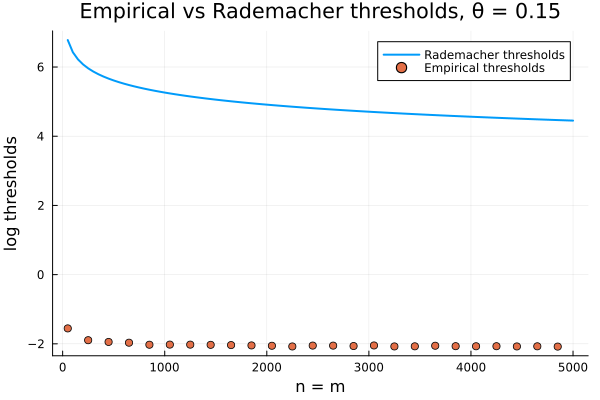

In [6]:
emp_radem_plot_fixed_theta

In [7]:
filepath = joinpath(pwd(), "ch4")
savefig(emp_radem_plot_fixed_theta, joinpath(filepath, "emp_radem_plot_fixed_theta.png"))


"c:\\Users\\User\\Desktop\\Two-samples-test\\ch4\\emp_radem_plot_fixed_theta.png"

Now we see the comparison between empirical and theoretical thresholds per $\theta$ for fixed $n$ and $m$.

In [8]:
function emp_vs_theor_vary_theta(q_1::PPM, q_2::PPM, n::Int, m::Int, s::Int)
    # q_1: law of RPM
    # q_2: law of RPM
    # n: number of probability measures from which observations are generated
    # m: number of observations from each probability measure
    # s: number of times to sample distance between hierarchical measures

    # This functions firstly gets empirical thresholds per θ for fixed n and m. 
    # Then it gets rademacher thresholds per θ for fixed n and m, and compares it to the empirical thresholds.

    k = q_1.b-q_1.a
    @assert (q_1.b == q_2.b) && (q_1.a == q_2.a) "sample space should be same"
    θs = collect(0.01:0.01:1.0) # list of probability levels
    
    

    d_lips = sample_distances(q_1, q_2, n, m, s) 
    emp_thresholds = quantile(d_lips, 1 .- θs)
    radem_thresholds = rademacher_threshold.(n, m, θs, k)

    emp_radem_plot = plot(xlabel = "θ", ylabel ="log thresholds", title = "Empirical vs Rademacher thresholds, n = m = $n", legend = :topright)
    plot!(emp_radem_plot, θs, log.(emp_thresholds), label = "Empirical thresholds", lw = 2)
    plot!(emp_radem_plot, θs, log.(radem_thresholds), label = "Rademacher thresholds", lw = 2)
    return emp_thresholds, radem_thresholds, emp_radem_plot
end


emp_vs_theor_vary_theta (generic function with 1 method)

In [9]:
function probability(baseMeasure::String)
    # function to generate observation either from uniform(-1/2,1/2) or from splitting measure
    if baseMeasure == "same" # Uniform(-1/2,1/2)
        return rand() - 0.5
    elseif baseMeasure == "splitting"  # sample either close to -1 or close to 1
        atom = rand()
        mixture = rand((0,1))
        return mixture * ( -1. + 0.25 * atom ) + (1 - mixture) * (0.75 + 0.25 * atom)
    end

end

# simulations for Dirichlet

Random.seed!(123456)


α_1, α_2 = 1.0, 2.0
P_0_1 = ()->probability("same")
P_0_2 = ()->probability("splitting")

a, b = -1.0, 1.0

q_1 = DP(α_1, P_0_2, a, b)
q_2 = DP(α_2, P_0_2, a, b)


n = 500
m = 500
s = 150


emp_th, rad_th, emp_radem_plot_vary_theta = emp_vs_theor_vary_theta(q_1, q_2, n, m, s)

([0.15756664640000012, 0.1544613034666668, 0.15311644106666678, 0.1510904768000001, 0.14942709600000015, 0.14896995733333343, 0.1476564688000001, 0.14654651946666683, 0.14524220053333348, 0.14462337066666678  …  0.09994412480000009, 0.09983776000000008, 0.09926730133333342, 0.09809194618629909, 0.09747109773057615, 0.09691477547050414, 0.09290544373333341, 0.08863046826666676, 0.08565432106666673, 0.0777976533333334], [276.3883425157351, 275.74142659937223, 275.34049039753137, 275.0442768898073, 274.8070110411969, 274.60782300170354, 274.43537336775654, 274.2827884236717, 274.14557491797615, 274.0206284045868  …  270.53591052530624, 270.51043523129584, 270.48505916911023, 270.45977842574615, 270.4345891616755, 270.40948760635956, 270.3844700539256, 270.35953285899205, 270.3346724326313, 270.3098852384563], Plot{Plots.GRBackend() n=2})

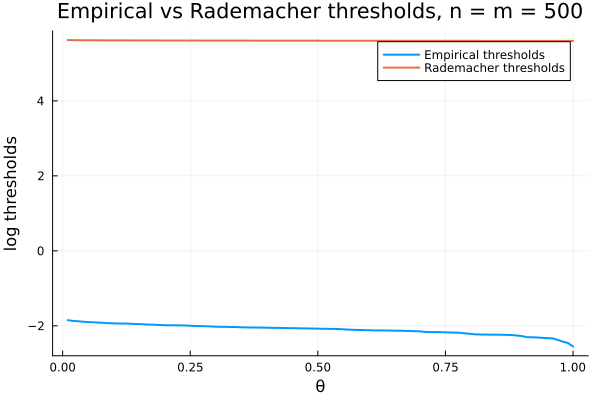

In [10]:
emp_radem_plot_vary_theta

In [11]:
filepath = joinpath(pwd(), "ch4")
savefig(emp_radem_plot_vary_theta, joinpath(filepath, "emp_radem_plot_vary_theta.png"))


"c:\\Users\\User\\Desktop\\Two-samples-test\\ch4\\emp_radem_plot_vary_theta.png"